### PHYSICAL REVIEW LETTERS 122, 047702 (2019) results:

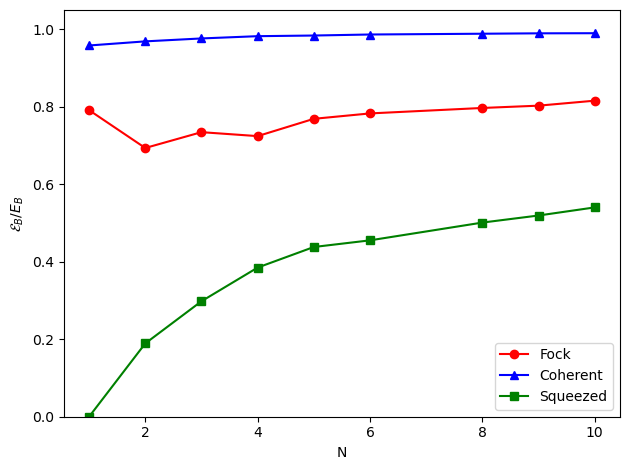

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt


def ergotropy(rho, H):
    r = np.sort(rho.eigenenergies())[::-1]
    e = np.sort(H.eigenenergies())
    return qt.expect(H, rho) - np.sum(r * e)


def collective_ops(N):
    sp, sm, I = qt.sigmap(), qt.sigmam(), qt.qeye(2)
    Sp = qt.jmat(N/2,'+')
    Sm = Sp.dag()
    Sz = qt.jmat(N/2,'z')
    HB = Sz+N/2*qt.qeye(N+1)
    return Sp, Sm, HB


def simulate_N(N, kind):
    nmax = 20
    a = qt.destroy(nmax)

    Sp, Sm, HB = collective_ops(N)
    IB = qt.qeye(N+1)

    H = (qt.tensor(a.dag()*a, IB)
       + qt.tensor(qt.qeye(nmax), HB)
       + qt.tensor(a, Sp)
       + qt.tensor(a.dag(), Sm))

    if kind == "fock":
        psiA = qt.basis(nmax, N)
    elif kind == "coherent":
        psiA = qt.coherent(nmax, np.sqrt(N))
    elif kind == "squeezed":
        psiA = qt.squeeze(nmax, np.arcsinh(np.sqrt(N))) * qt.basis(nmax, 0)

    psiB0 = qt.basis(N+1,N)
    psi0 = qt.tensor(psiA, psiB0)

    t = np.pi/np.sqrt(N)
    tlist = np.linspace(0,t,100)
    eops = qt.tensor(qt.qeye(nmax), HB)
    sol = qt.mesolve(H, psi0, tlist,e_ops=eops)
    Eblist = np.transpose(sol.expect).ravel()
    power = Eblist[1:-1]/tlist[1:-1]
    indx = np.argmax(power)
    t = tlist[indx]
    rho = qt.mesolve(H, psi0, [0, t]).states[-1]
    rhoB = rho.ptrace(1)
    
    return ergotropy(rhoB, HB) / qt.expect(HB, rhoB)


Ns = [1, 2, 3, 4, 5, 6, 8, 9, 10]
states = ["fock", "coherent", "squeezed"]

data = {s: [simulate_N(N, s) for N in Ns] for s in states}

plt.plot(Ns, data["fock"], "o-", color='red', label="Fock")
plt.plot(Ns, data["coherent"], "^-", color='blue', label="Coherent")
plt.plot(Ns, data["squeezed"], "s-",color='green', label="Squeezed")
plt.xlabel("N")
plt.ylabel(r"$\mathcal{E}_B / E_B$")
plt.legend(loc='lower right')
plt.tight_layout()
plt.ylim(0,1.05)
plt.show()

/var/folders/mz/8z6t7nxj1rzg2jvg9_6hk8km0000gn/T/ipykernel_12836/1837450417.py:112: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(Erg, EB)


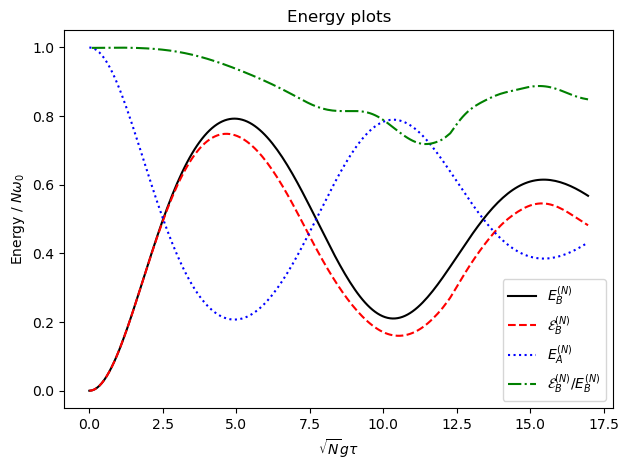

In [12]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# =================================================
# Parameters 
# =================================================
N      = 8
g      = 1.0
w0     = 1.0
w      = 1.0
nmax   = 20
times  = np.linspace(0, 6, 200)

#========= rescaled time axis =====================

x = np.sqrt(N) * g * times

# =================================================
# Bosonic operators (charger)
# =================================================

a  = qt.destroy(nmax)
Ic = qt.qeye(nmax)

#==================================================
# spin operators (single qubit)
#==================================================

sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
sp, sm     = qt.sigmap(), qt.sigmam()

#=================================================
# tensor embedding operators
#=================================================

def embed(op, i):
    ops = [qt.qeye(2)] * N         # This function places a single-spin operator on site i while leaving all other spins untouched.
    ops[i] = op
    return qt.tensor(ops)          # This builds operators in the full 2ᴺ-dimensional battery Hilbert space

#=================================================
# Collective battery operators
#=================================================

Sp = sum(embed(sp, i) for i in range(N))
Sm = Sp.dag()
Sz = 0.5 * sum(embed(sz, i) for i in range(N))

IB = qt.tensor([qt.qeye(2)] * N)

# =================================================
# Hamiltonian
# =================================================

HB = w0 * qt.tensor(Sz + 0.5 * N * IB, Ic)
HA = w  * qt.tensor(IB, a.dag() * a)

H_int = (g / np.sqrt(N)) * (qt.tensor(Sp, a) + qt.tensor(Sm, a.dag()))

H = HB + HA + H_int

# =================================================
# Initial state
# =================================================

psiB = qt.tensor([qt.basis(2, 1) for _ in range(N)])
psiA = qt.coherent(nmax, np.sqrt(N))

psi0 = qt.tensor(psiB, psiA)

# =================================================
# Time evolution
# =================================================

result = qt.sesolve(H, psi0, times)

# =================================================
# Battery & Charger Hamiltonians
# =================================================

H_B = w0 * (Sz + 0.5 * N * IB)
H_A = w  * (a.dag() * a)

# =================================================
# Ergotropy
# =================================================

def ergotropy(rho, H):
    p = np.sort(rho.eigenstates()[0])[::-1]   
    e = np.sort(H.eigenenergies())
    return qt.expect(H, rho) - np.sum(p * e)

# =================================================
# Observables
# =================================================

EB, EA, Erg = [], [], []

for psi in result.states:
    rhoB = psi.ptrace(list(range(N)))
    rhoA = psi.ptrace(N)

    EB.append(qt.expect(H_B, rhoB))
    EA.append(qt.expect(H_A, rhoA))
    Erg.append(ergotropy(rhoB, H_B))

EB  = np.array(EB)  / (N * w0)
EA  = np.array(EA)  / (N * w0)
Erg = np.array(Erg) / (N * w0)

ratio = np.divide(Erg, EB)

# =================================================
# Energy Plots
# =================================================

plt.plot(x, EB,    'k-',  label=r'$E_B^{(N)}$')
plt.plot(x, Erg,   'r--', label=r'$\mathcal{E}_B^{(N)}$')
plt.plot(x, EA,    'b:',  label=r'$E_A^{(N)}$')
plt.plot(x, ratio, 'g-.', label=r'$\mathcal{E}_B^{(N)}/E_B^{(N)}$')

plt.xlabel(r'$\sqrt{N} g \tau$')
plt.ylabel(r'Energy / $N\omega_0$')
plt.title("Energy plots")
plt.legend()
plt.tight_layout()
plt.show()